In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.squeeze().detach().numpy()
    plt.figure(figsize=(5,5))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [3]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=32,kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32,out_channels=64,kernel_size=4,stride=2, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64,out_channels=64,kernel_size=4,stride=2, padding=1)
        self.batchNorm1 = nn.BatchNorm2d(32)
        self.batchNorm2 = nn.BatchNorm2d(64)
        self.relu = nn.LeakyReLU(0.2)
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(0.2)
        self.dense = nn.Linear(64 * 4 * 4, 1)
        self.sigm = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.batchNorm1(self.conv1(x)))
        x = self.relu(self.batchNorm2(self.conv2(x)))
        x = self.relu(self.batchNorm2(self.conv3(x)))
        x = self.flatten(x)
        x = self.dropout(x)
        x = self.sigm(self.dense(x))
        return x

discriminator = Discriminator()
# discriminator.apply(weights_init)

In [4]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.fc1 = nn.Linear(64, 1024)

        self.deconv1 = nn.ConvTranspose2d(64, 64, kernel_size=4, stride=2, padding=1)
        self.deconv2 = nn.ConvTranspose2d(64, 128, kernel_size=4, stride=2, padding=1)
        self.deconv3 = nn.ConvTranspose2d(128, 256, kernel_size=4, stride=2, padding=1)

        self.final_deconv = nn.Conv2d(256, 3, kernel_size=5, stride=1, padding=2)

        self.relu = nn.LeakyReLU(0.2)
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = self.fc1(x)
        x = x.view(-1, 64, 4, 4)
        x = self.relu(self.deconv1(x))
        x = self.relu(self.deconv2(x))
        x = self.relu(self.deconv3(x))
        x = self.tanh(self.final_deconv(x))
        return x

generator = Generator()
# generator.apply(weights_init)

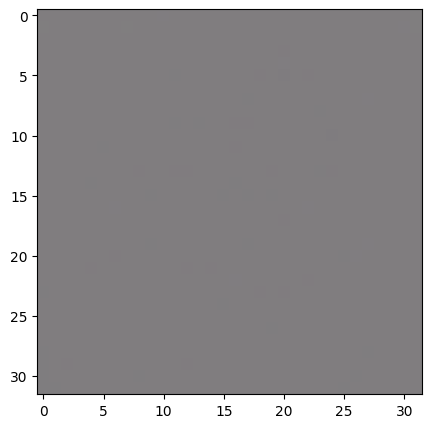

In [5]:
random_noise = torch.randn(1, 64)
generated_image = generator(random_noise)
imshow(generated_image)

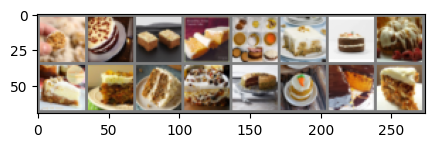

In [6]:
# wczytanie crawled_cakes i przeskalowanie do 32x32 oraz normalizacja do [-1,1]

transform = transforms.Compose(
    [transforms.Resize((32, 32)),
     transforms.ToTensor(),
     transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])

trainset = torchvision.datasets.ImageFolder(root='train', transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=16, shuffle=True, num_workers=2)

dataiter = iter(trainloader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images))

In [7]:
class SmallModel(nn.Module):
    def __init__(self):
        super(SmallModel, self).__init__()
        self.dense1 = nn.Linear(3, 3)
        self.dense2 = nn.Linear(3, 3)

    def forward(self, x):
        x = self.dense1(x)
        x = self.dense2(x)
        return x

model = SmallModel()

x = torch.randn(3, 3)

def loss_function(x):
    return torch.mean(x) - 42

optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

for i in range(10):
    output = model(x)
    loss = loss_function(output)
    loss.backward()
    optimizer.step()
    print(loss)

tensor(-42.1327, grad_fn=<SubBackward0>)
tensor(-42.1394, grad_fn=<SubBackward0>)
tensor(-42.1529, grad_fn=<SubBackward0>)
tensor(-42.1734, grad_fn=<SubBackward0>)
tensor(-42.2011, grad_fn=<SubBackward0>)
tensor(-42.2365, grad_fn=<SubBackward0>)
tensor(-42.2801, grad_fn=<SubBackward0>)
tensor(-42.3325, grad_fn=<SubBackward0>)
tensor(-42.3945, grad_fn=<SubBackward0>)
tensor(-42.4672, grad_fn=<SubBackward0>)


In [8]:
# najlepszy wynik padł dla epoki 2550

gen_checkpoint = torch.load(
    'checkpoints/generator_checkpoint2550.tar', map_location=torch.device('cpu'))
generator.load_state_dict(gen_checkpoint['model_state_dict'])

<All keys matched successfully>

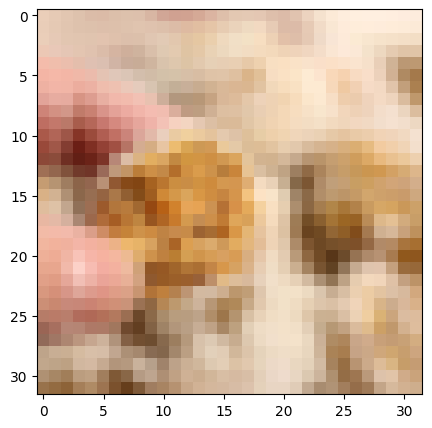

tensor([[-0.9602, -0.4166, -1.5763,  0.3477, -0.6132,  1.1369, -0.7921,  0.1921,
         -0.2167, -0.7821, -0.6917, -0.1314, -0.4366, -0.0222, -1.7377,  0.6749,
         -0.3332, -0.0831,  0.1286, -0.6932, -1.9080, -0.9016, -0.0862,  0.6881,
          0.0809, -1.7960,  0.9377,  0.1249,  0.7653, -2.9331,  0.5246, -2.5099,
          0.9594, -0.5146,  0.6333,  0.6118,  0.9513, -0.0449,  0.1557, -0.6628,
         -1.4301, -0.6710, -0.5071,  0.5858,  0.9231, -0.1714, -0.5426, -1.5315,
         -0.0602, -0.4200, -0.2818, -0.2624,  1.1246, -0.1439,  0.1383, -0.2457,
         -0.1146,  0.6507, -0.4835,  1.4915, -0.2781, -0.1901,  1.3655,  0.4150]],
       requires_grad=True)


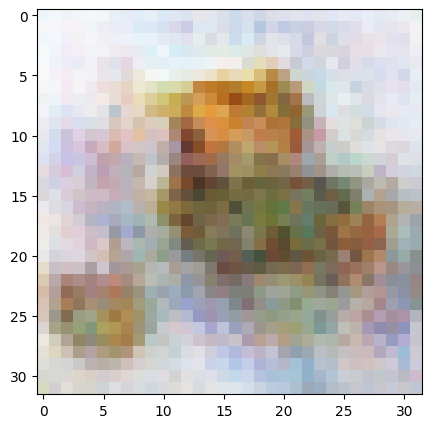

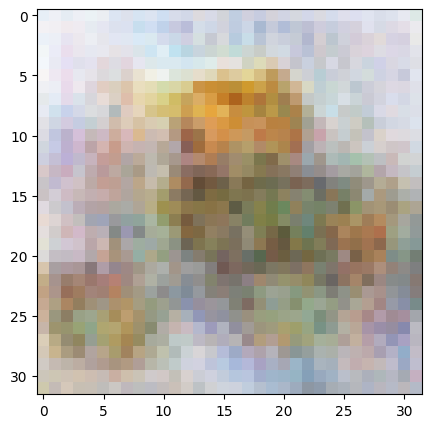

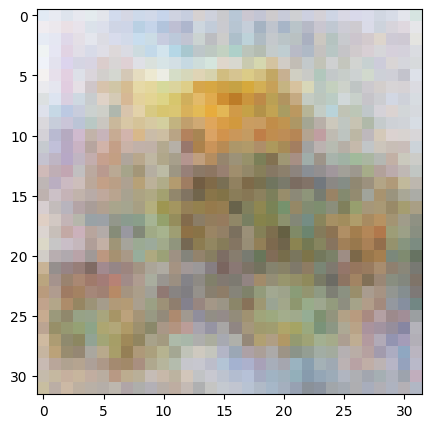

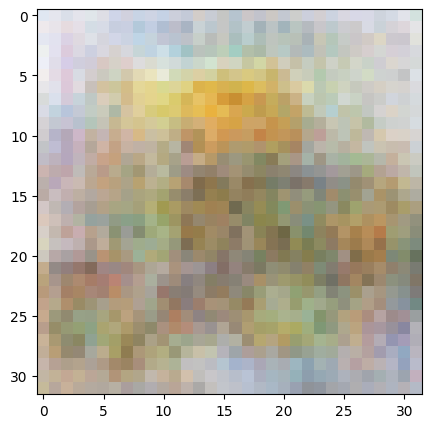

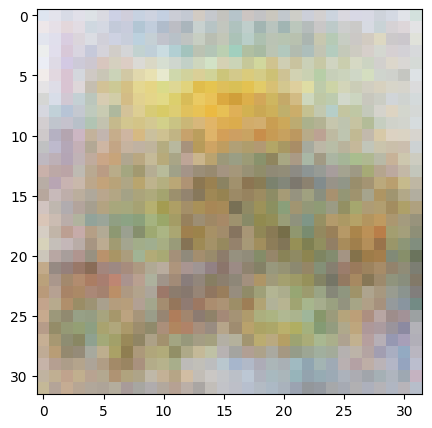

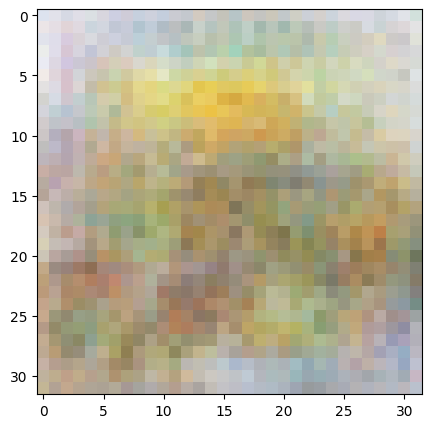

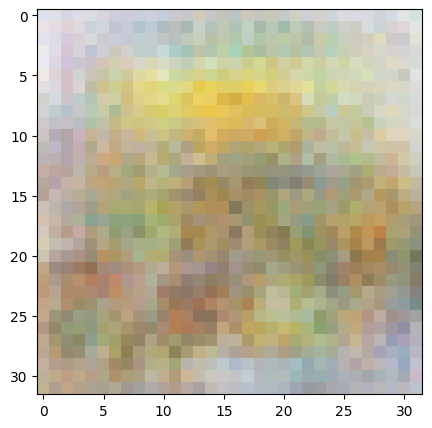

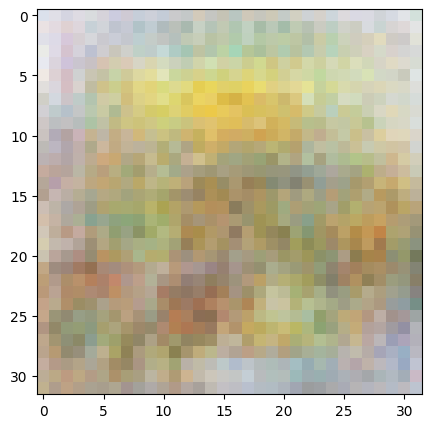

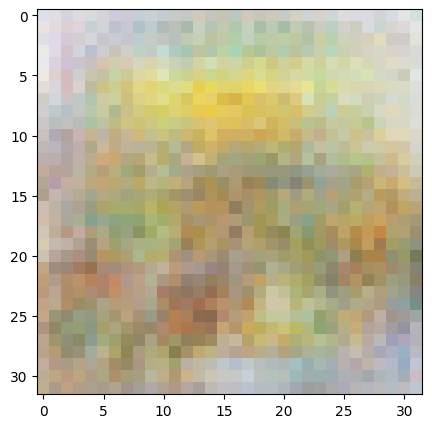

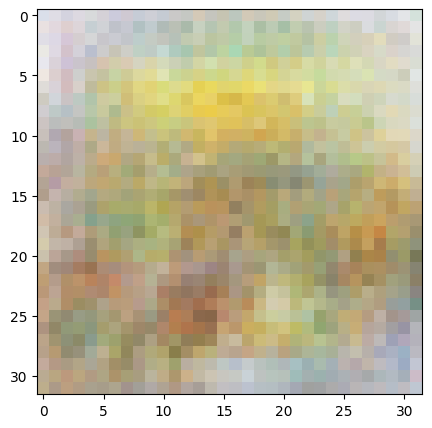

tensor([[-0.2505,  0.1846, -1.5693,  0.3118, -0.6592,  1.1049, -0.5438, -0.1911,
         -0.4161, -0.6035, -0.4467, -0.3225, -0.0051, -0.3129, -1.2190,  0.1296,
         -0.4481, -0.0048,  0.0147, -0.3681, -1.7041, -1.5310, -0.1471,  0.5616,
          0.0691, -1.5042,  1.2956,  0.4185,  1.0153, -2.2862,  1.1634, -2.2816,
          0.8754, -0.8328,  0.3912,  0.8037,  0.3162, -0.1065,  0.5797, -1.1694,
         -1.4321, -0.9112, -0.2240,  0.2764,  0.6712,  0.1010, -0.0837, -1.2516,
         -0.2773, -0.8575, -0.2143, -0.0435,  0.9334,  0.0950,  0.5513,  0.2231,
          0.5125,  1.0848, -0.5557,  0.6089, -0.2298, -0.5908,  1.3724,  0.0502]],
       requires_grad=True)


In [9]:
real_image = images[0]
imshow(real_image)

random_vector = torch.randn(1, 64, requires_grad=True)  # Dodaj requires_grad=True, aby śledzić gradienty
print(random_vector)
loss_function = nn.MSELoss()
optimizer = torch.optim.SGD([random_vector], lr=0.01, momentum=0.9)

for i in range(1000):
    optimizer.zero_grad()
    fake_image = generator(random_vector)
    if i % 100 == 0:
        imshow(fake_image)
    loss = loss_function(fake_image.squeeze(), real_image)
    loss.backward()
    optimizer.step()
print(random_vector)
final_vector = random_vector.detach().clone()

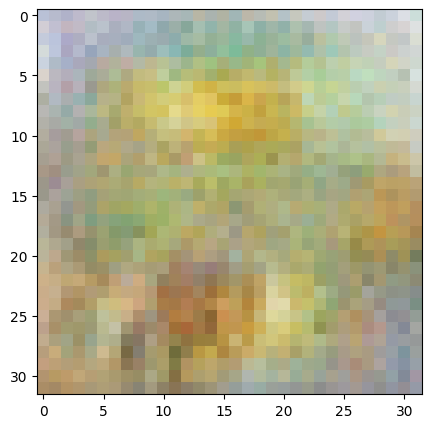

In [11]:
import random
changed_vector = final_vector.clone()
random_indices = random.sample(range(64), 10)
changed_vector[0, random_indices] = torch.randn(10)
imshow(generator(changed_vector))

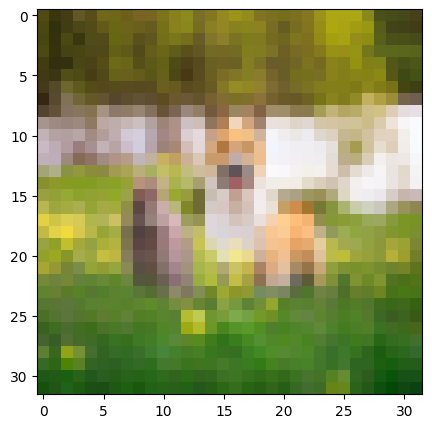

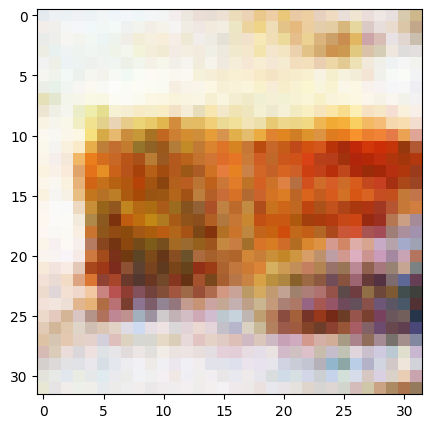

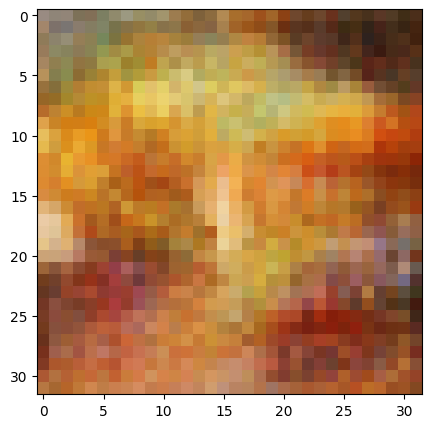

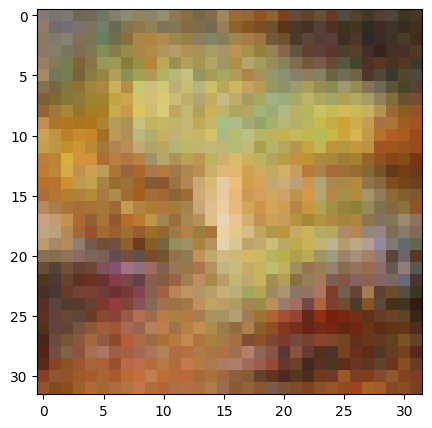

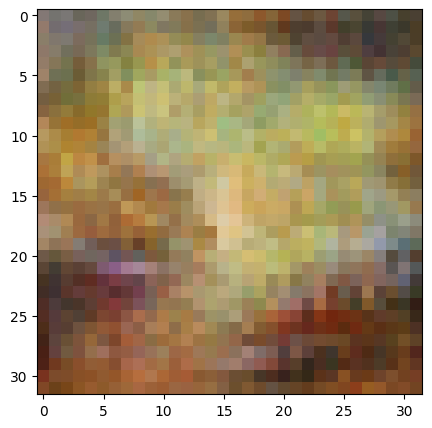

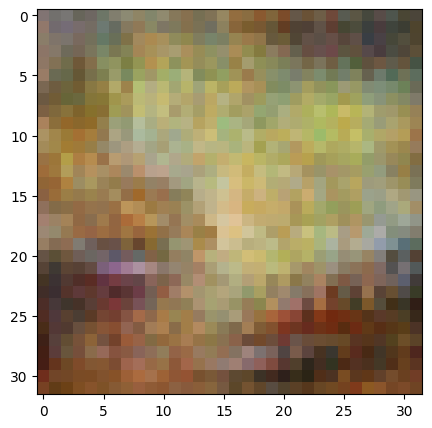

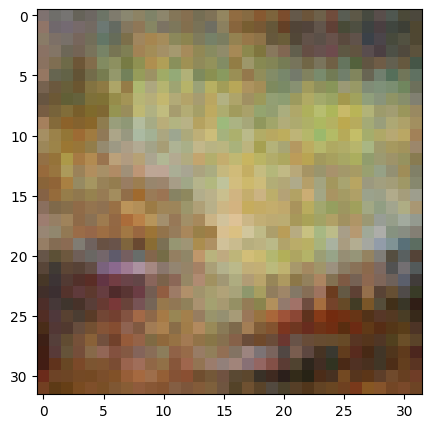

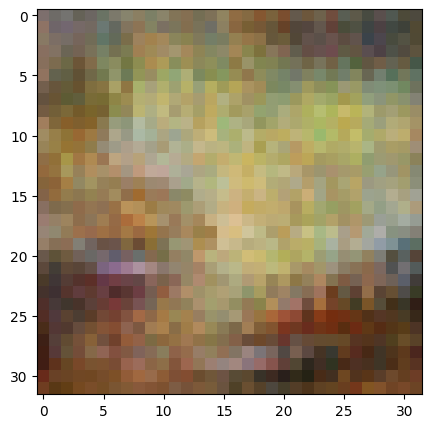

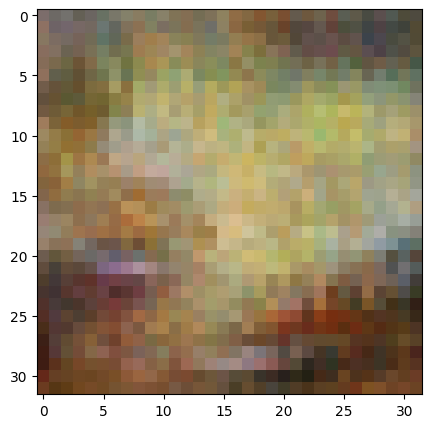

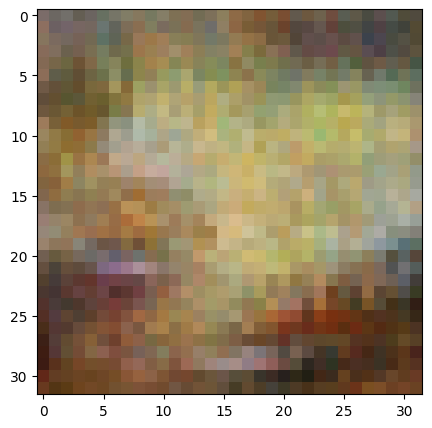

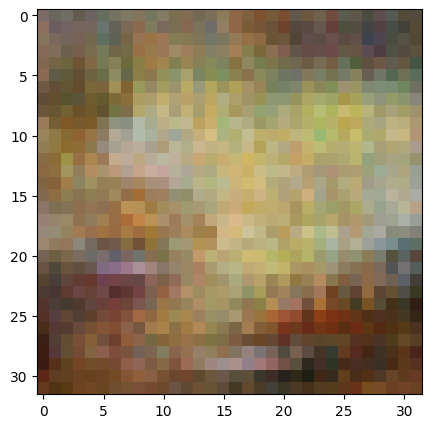

In [12]:
from PIL import Image

wrong_image = Image.open('cat_dog.jpg').convert('RGB').resize((32, 32))
wrong_image = transforms.ToTensor()(wrong_image)
wrong_image = (wrong_image - 0.5) / 0.5
imshow(wrong_image)

wrong_random_vector = torch.randn(1, 64, requires_grad=True)  # Dodaj requires_grad=True, aby śledzić gradienty
loss_function = nn.MSELoss()
optimizer = torch.optim.SGD([wrong_random_vector], lr=0.01, momentum=0.9)

for i in range(1000):
    optimizer.zero_grad()
    fake_image = generator(wrong_random_vector)
    if i % 100 == 0:
        imshow(fake_image)
    loss = loss_function(fake_image.squeeze(), wrong_image)
    loss.backward()
    optimizer.step()

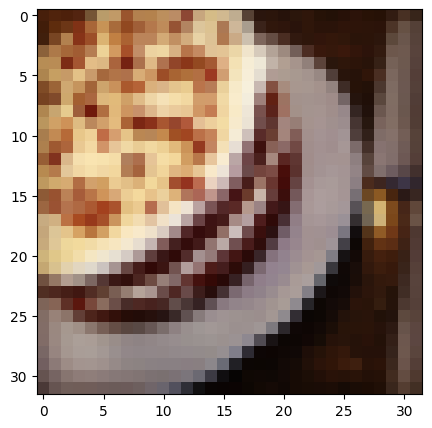

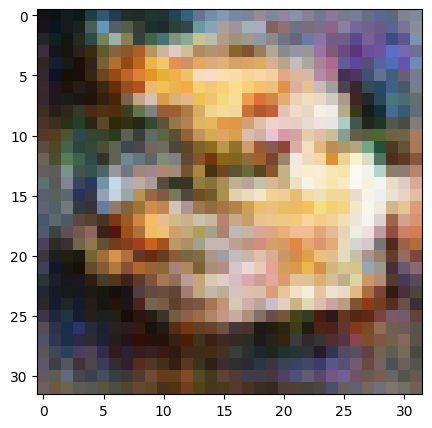

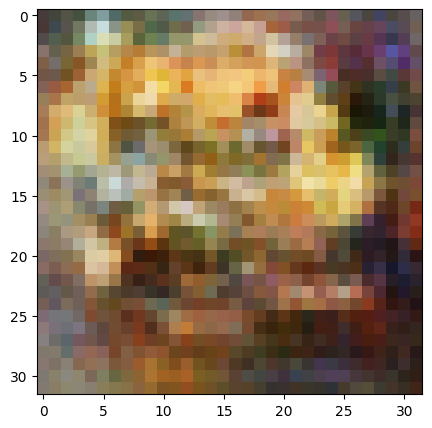

In [14]:
another_image = images[1]
imshow(another_image)

another_vector = torch.randn(1, 64, requires_grad=True)
optimizer = torch.optim.SGD([another_vector], lr=0.01, momentum=0.9)

for i in range(1000):
    optimizer.zero_grad()
    fake_image = generator(another_vector)
    if i % 1000 == 0:
        imshow(fake_image)
    loss = loss_function(fake_image.squeeze(), another_image)
    loss.backward()
    optimizer.step()
final_another_vector = another_vector.detach().clone()
imshow(generator(final_another_vector))

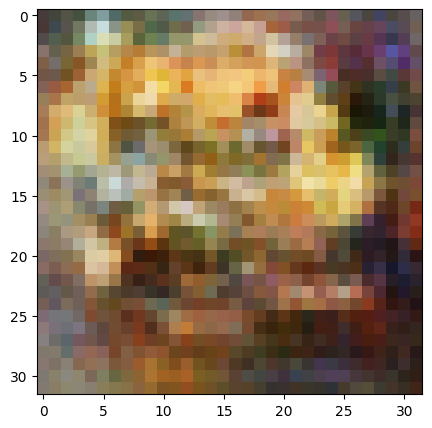

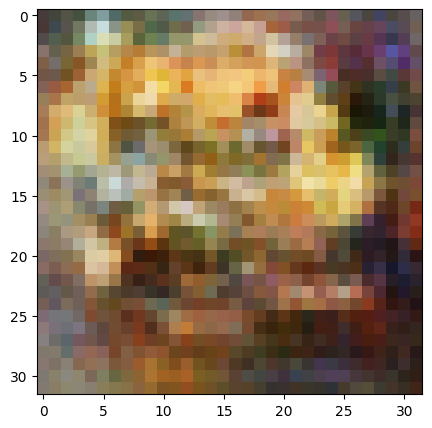

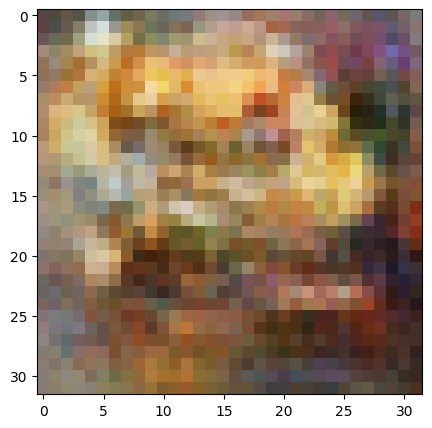

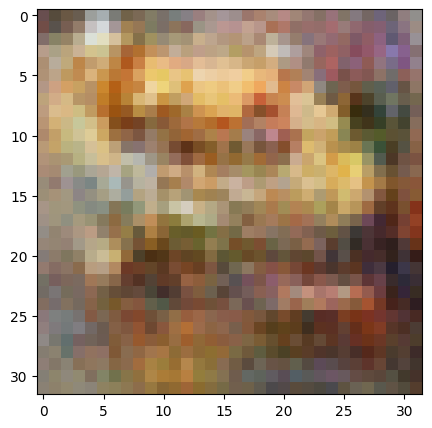

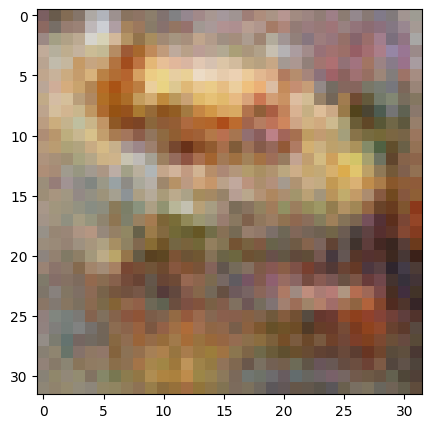

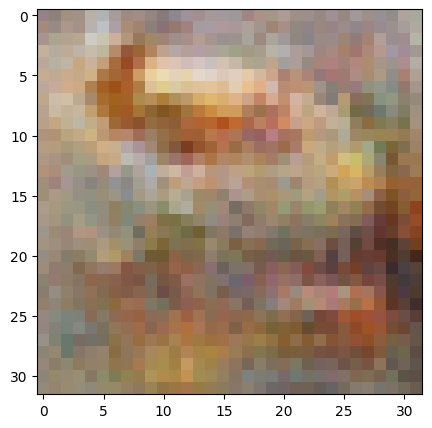

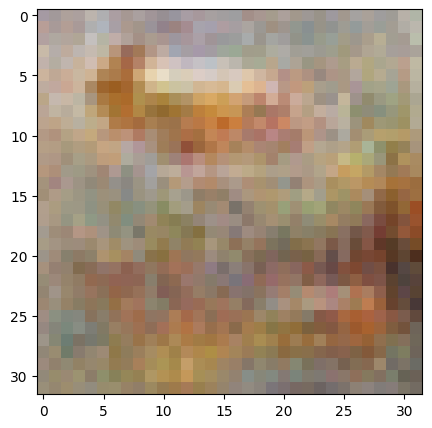

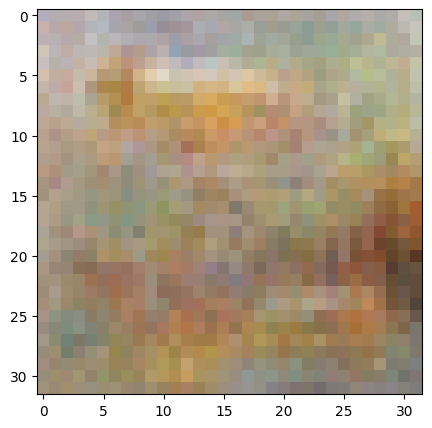

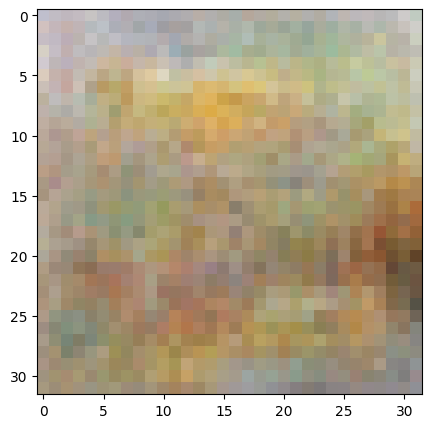

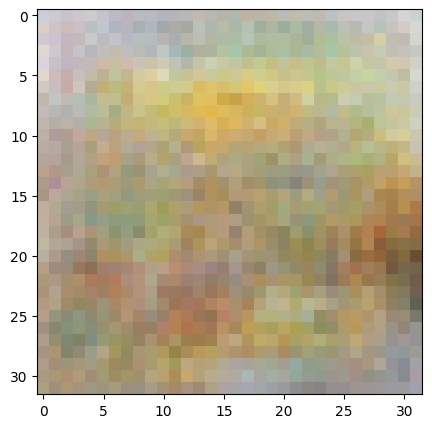

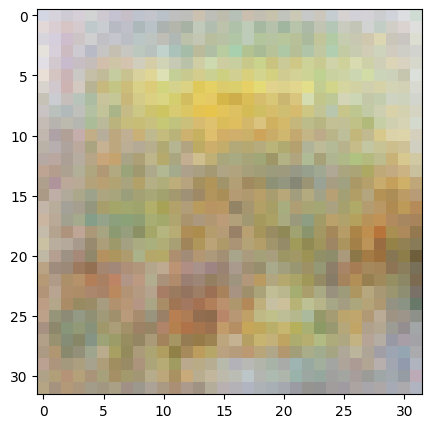

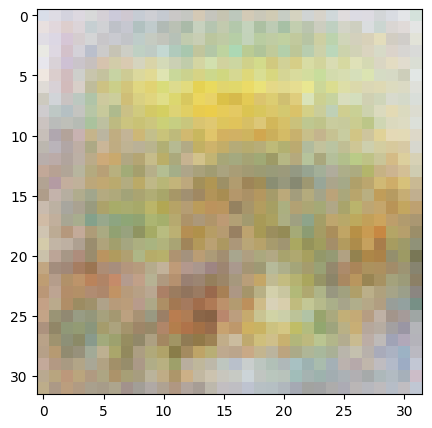

In [15]:
imshow(generator(final_another_vector))
vectors = []
for i in range(10):
    vectors.append(final_vector * i / 10 + final_another_vector * (10 - i) / 10)
    imshow(generator(vectors[-1]))
imshow(generator(final_vector))